# Benötigte Libraries und Environment einrichten

In [127]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import copy

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

# Avalanche imports
from avalanche.benchmarks.generators import dataset_benchmark
from avalanche.benchmarks.utils import make_classification_dataset
from avalanche.evaluation.metrics import accuracy_metrics, confusion_matrix_metrics, loss_metrics, forgetting_metrics, forward_transfer_metrics, images_samples_metrics, StreamAccuracy, StreamConfusionMatrix
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training import Naive, MAS, EWC      # used training strategies

# Setup CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check PyTorch version and CUDA availability
print("Pytorch version:", torch.version.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("device:", device)

Pytorch version: 2.0.1
CUDA available: True
CUDA version: 11.7
device: cuda:0


# Daten in ein Dataframe einlesen und vorverarbeiten

In [128]:
# Readin annotations file
df = pd.read_excel('../data/annotations.xlsx')

# Extract the first number using regular expression and create a new column
df['Schweißnahtnummer'] = df['img_path'].str.extract(r'(\d+)')
df['Cutout name'] = (df['Schweißnahtnummer'])
df['Cutout name'] = df['Cutout name'] + '_' + df['filename']
# Interchange the substring in the img_path column
df['img_path'] = df['img_path'].str.replace('../data/raw/hx_fsw/images', '../data/hx_training_classify')

# Get column names except the first three columns
other_columns = df.columns[3:]
# Reorder columns by concatenating the other columns with the first three columns
df = df[other_columns.tolist() + df.columns[:3].tolist()]

# Reorder columns by moving "Schweißnahtnummer" to the front
df_col = df['Schweißnahtnummer']
df.drop(columns=['Schweißnahtnummer'], inplace=True)
df.insert(0, 'Schweißnahtnummer', df_col)
df_col = df['Cutout name']
df.drop(columns=['Cutout name'], inplace=True)
df.insert(1, 'Cutout name', df_col)
df_col = df['img_path']
df.drop(columns=['img_path'], inplace=True)
df.insert(8, 'img_path', df_col)
# rename column Cutout name to Cutout_name
df.rename(columns={'Cutout name': 'Cutout_name'}, inplace=True)

# Create the column Parametergruppe
# Create a dictionary to map the ranges of Schweißnahtnummer to Parametergruppe values
# Change the datatype of the column Schweißnahtnummer to int
df['Schweißnahtnummer'] = df['Schweißnahtnummer'].astype(int)
group_mapping = {
    range(1, 17): 1,
    range(17,19): 0,
    range(19, 35): 2,
    range(35, 51): 3,
    range(51, 67): 4,
    range(67, 83): 5,
    range(83, 99): 6,
    range(99, 115): 7
}
# Apply the mapping to create the Parametergruppe column
df['Parametergruppe'] = df['Schweißnahtnummer'].apply(lambda x: next((val for key, val in group_mapping.items() if x in key), None))
df['Parametergruppe'] = df['Parametergruppe'].astype(int)
# Change the position of the column Parametergruppe to second
df_col = df['Parametergruppe']
df.drop(columns=['Parametergruppe'], inplace=True)
df.insert(1, 'Parametergruppe', df_col)

# Extract the numbers from the Cutout_name column using regular expressions
df[['Num1', 'Num2', 'Num3']] = df['Cutout_name'].str.extract(r'(\d+)_.*-(\d+)-(\d+)\.JPG')
# Convert the extracted columns to numeric
df[['Num1', 'Num2', 'Num3']] = df[['Num1', 'Num2', 'Num3']].astype(int)
# Sort the DataFrame based on the extracted numbers
df = df.sort_values(['Num1', 'Num2', 'Num3'])
# Drop the extracted number columns if not needed
df = df.drop(['Num1', 'Num2', 'Num3'], axis=1)
# Reset the index if desired
df = df.reset_index(drop=True)

# Drop the columns "Unnamed: 0" and "begin" and "end"
df.drop(columns=['Unnamed: 0', 'begin', 'end'], inplace=True)

C:\Users\JanHe\AppData\Local\Temp\ipykernel_34556\3119831208.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['img_path'] = df['img_path'].str.replace('../data/raw/hx_fsw/images', '../data/hx_training_classify')


In [129]:
# Create the column containing the tensors of the images
# Create a new column called img_array_color that reads in the image which is located in the img_path column
df['img_array_color'] = df['img_path'].map(lambda x: np.asarray(Image.open(x)))
# Normalize the images in the img_array_color_resized column
df['img_array_color_normalized'] = df['img_array_color'].map(lambda x: x/255)
# Transform the images to permuted tensors with the shape (3, 300, 100)
# and change the the datatype of all the tensors in the column img_tensor_color from torch.float64 to torch.float32 
# -> increases the speed of the training tremendously and there is no loss of accuracy
df['img_tensor_color'] = df['img_array_color_normalized'].map(lambda x: torch.from_numpy(x).permute(2, 0, 1).to(torch.float32))

# Datensatz in die 7 Parametergruppen aufteilen, in Avalanche Classification Datasets umwandeln und in Trainings- und Testdatensätze aufteilen

In [130]:
# Create a dataframe for each parametergroup
df_1 = df[df['Parametergruppe'] == 1]
df_2 = df[df['Parametergruppe'] == 2]
df_3 = df[df['Parametergruppe'] == 3]
df_4 = df[df['Parametergruppe'] == 4]
df_5 = df[df['Parametergruppe'] == 5]
df_6 = df[df['Parametergruppe'] == 6]
df_7 = df[df['Parametergruppe'] == 7]

print(len(df_1) + len(df_2) + len(df_3) + len(df_4) + len(df_5) + len(df_6) + len(df_7))
len(df_1), len(df_2), len(df_3), len(df_4), len(df_5), len(df_6), len(df_7)

8324


(950, 966, 858, 1532, 1066, 1522, 1430)

In [131]:
# Create a custom dataset that inherits from torch.utils.data.Dataset
class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.img = torch.stack(tuple(df['img_tensor_color'].values))        # stack the images in the img_tensor_color column (torch.stack needs a tuple as input)
        self.label_raw = df.iloc[:,7].values
        self.label = torch.tensor(self.label_raw, dtype=torch.int64)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.img[idx,:,:,:], self.label[idx]

In [132]:
# Create a PyTorch dataset for each parametergroup
group_1 = DataFrameDataset(df_1)
group_2 = DataFrameDataset(df_2)
group_3 = DataFrameDataset(df_3)
group_4 = DataFrameDataset(df_4)
group_5 = DataFrameDataset(df_5)
group_6 = DataFrameDataset(df_6)
group_7 = DataFrameDataset(df_7)

print(len(group_1) + len(group_2) + len(group_3) + len(group_4) + len(group_5) + len(group_6) + len(group_7))
len(group_1), len(group_2), len(group_3), len(group_4), len(group_5), len(group_6), len(group_7)

8324


(950, 966, 858, 1532, 1066, 1522, 1430)

In [133]:
# Use 100% of the available training data
# Split the PyTorch datasets for each parametergroup into train and test set (and trash set which won't be used -> just so the training and testing datasets have the same sizes)
# before I create the Avalanche classification datasets for each parametergroup
train_ratio = 0.8   # percentage of the data which is used for training -> rest of the data is used for testing

# Ratios to reduce all the training datasets to the same size as the smallest training dataset
equality_ratio_1 = len(group_3) / len(group_1)  
equality_ratio_2 = len(group_3) / len(group_2)
equality_ratio_4 = len(group_3) / len(group_4)
equality_ratio_5 = len(group_3) / len(group_5)
equality_ratio_6 = len(group_3) / len(group_6)
equality_ratio_7 = len(group_3) / len(group_7)

# Print the first entry (size of training dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(equality_ratio_1*train_ratio*len(group_1)), int(equality_ratio_2*train_ratio*len(group_2)), int(train_ratio*len(group_3)), int(equality_ratio_4*train_ratio*len(group_4)), int(equality_ratio_5*train_ratio*len(group_5)), int(equality_ratio_6*train_ratio*len(group_6)), int(equality_ratio_7*train_ratio*len(group_7))))
# Print the second entry (size of testing dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(0.182 * len(group_1)), int(0.179 * len(group_2)), int(0.201 * len(group_3)), int(0.1125 * len(group_4)), int(0.162 * len(group_5)), int(0.1135 * len(group_6)), int(0.1205 * len(group_7))))
# Print the third entry (size of trash dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(0.097 * len(group_1)), int(0.112 * len(group_2)), int(0 * len(group_3)), int(0.4405 * len(group_4)), int(0.196 * len(group_5)), int(0.4365 * len(group_6)), int(0.4 * len(group_7))))

group_1_train, group_1_test, group_1_trash = torch.utils.data.random_split(group_1, [int(equality_ratio_1*train_ratio*len(group_1)), int(0.182 * len(group_1)), int(0.097 * len(group_1))])
group_2_train, group_2_test, group_2_trash = torch.utils.data.random_split(group_2, [int(equality_ratio_2*train_ratio*len(group_2)), int(0.179 * len(group_2)), int(0.112 * len(group_2))])
group_3_train, group_3_test = torch.utils.data.random_split(group_3, [int(train_ratio*len(group_3)), int(0.201 * len(group_3))])
group_4_train, group_4_test, group_4_trash = torch.utils.data.random_split(group_4, [int(equality_ratio_4*train_ratio*len(group_4)), int(0.1125 * len(group_4)), int(0.4405 * len(group_4))])
group_5_train, group_5_test, group_5_trash = torch.utils.data.random_split(group_5, [int(equality_ratio_5*train_ratio*len(group_5)), int(0.162 * len(group_5)), int(0.196 * len(group_5))])
group_6_train, group_6_test, group_6_trash = torch.utils.data.random_split(group_6, [int(equality_ratio_6*train_ratio*len(group_6)), int(0.1135 * len(group_6)), int(0.4365 * len(group_6))])
group_7_train, group_7_test, group_7_trash = torch.utils.data.random_split(group_7, [int(equality_ratio_7*train_ratio*len(group_7)), int(0.1205 * len(group_7)), int(0.4 * len(group_7))])

print("\nAnzahl Trainingsbilder:", len(group_1_train), len(group_2_train), len(group_3_train), len(group_4_train), len(group_5_train), len(group_6_train), len(group_7_train))
print("Anzahl Testbilder:", len(group_1_test), len(group_2_test), len(group_3_test), len(group_4_test), len(group_5_test), len(group_6_test), len(group_7_test),"\n")
print("Anzahl nicht genutzter Bilder pro Datensatz:", len(group_1_trash), len(group_2_trash), 0, len(group_4_trash), len(group_5_trash), len(group_6_trash), len(group_7_trash))


Anzahl Trainingsbilder: 686 686 686 686 686 686 686
Anzahl Testbilder: 172 172 172 172 172 172 172 

Anzahl nicht genutzter Bilder pro Datensatz: 92 108 0 674 208 664 572


In [134]:
"""# Use 50% of the available training data
# Split the PyTorch datasets for each parametergroup into train and test set (and trash set which won't be used -> just so the training and testing datasets have the same sizes)
# before I create the Avalanche classification datasets for each parametergroup
train_ratio = 0.4   # percentage of the data which is used for training -> rest of the data is used for testing

# Ratios to reduce all the training datasets to the same size as the smallest training dataset
equality_ratio_1 = len(group_3) / len(group_1)  
equality_ratio_2 = len(group_3) / len(group_2)
equality_ratio_4 = len(group_3) / len(group_4)
equality_ratio_5 = len(group_3) / len(group_5)
equality_ratio_6 = len(group_3) / len(group_6)
equality_ratio_7 = len(group_3) / len(group_7)

# Print the first entry (size of training dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(equality_ratio_1*train_ratio*len(group_1)), int(equality_ratio_2*train_ratio*len(group_2)), int(train_ratio*len(group_3)), int(equality_ratio_4*train_ratio*len(group_4)), int(equality_ratio_5*train_ratio*len(group_5)), int(equality_ratio_6*train_ratio*len(group_6)), int(equality_ratio_7*train_ratio*len(group_7))))
# Print the second entry (size of testing dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(0.182 * len(group_1)), int(0.179 * len(group_2)), int(0.201 * len(group_3)), int(0.1125 * len(group_4)), int(0.162 * len(group_5)), int(0.1135 * len(group_6)), int(0.1205 * len(group_7))))
# Print the third entry (size of trash dataset) for torch.utils.data.random_split of every parameter group (for debugging)
#print((int(0.458 * len(group_1)), int(0.467 * len(group_2)), int(0 * len(group_3)), int(0.6639 * len(group_4)), int(0.5175 * len(group_5)), int(0.662 * len(group_6)), int(0.64 * len(group_7))))

group_1_train, group_1_test, group_1_trash = torch.utils.data.random_split(group_1, [int(equality_ratio_1*train_ratio*len(group_1)), int(0.182 * len(group_1)), int(0.458 * len(group_1))])
group_2_train, group_2_test, group_2_trash = torch.utils.data.random_split(group_2, [int(equality_ratio_2*train_ratio*len(group_2)), int(0.179 * len(group_2)), int(0.467 * len(group_2))])
group_3_train, group_3_test, group_3_trash = torch.utils.data.random_split(group_3, [int(train_ratio*len(group_3)), int(0.201 * len(group_3)), int(train_ratio*len(group_3))])
group_4_train, group_4_test, group_4_trash = torch.utils.data.random_split(group_4, [int(equality_ratio_4*train_ratio*len(group_4)), int(0.1125 * len(group_4)), int(0.6639 * len(group_4))])
group_5_train, group_5_test, group_5_trash = torch.utils.data.random_split(group_5, [int(equality_ratio_5*train_ratio*len(group_5)), int(0.162 * len(group_5)), int(0.5175 * len(group_5))])
group_6_train, group_6_test, group_6_trash = torch.utils.data.random_split(group_6, [int(equality_ratio_6*train_ratio*len(group_6)), int(0.1135 * len(group_6)), int(0.662 * len(group_6))])
group_7_train, group_7_test, group_7_trash = torch.utils.data.random_split(group_7, [int(equality_ratio_7*train_ratio*len(group_7)), int(0.1205 * len(group_7)), int(0.64 * len(group_7))])

print("\nAnzahl Trainingsbilder:", len(group_1_train), len(group_2_train), len(group_3_train), len(group_4_train), len(group_5_train), len(group_6_train), len(group_7_train))
print("Anzahl Testbilder:", len(group_1_test), len(group_2_test), len(group_3_test), len(group_4_test), len(group_5_test), len(group_6_test), len(group_7_test),"\n")
print("Anzahl nicht genutzter Bilder pro Datensatz:", len(group_1_trash), len(group_2_trash), len(group_3_trash), len(group_4_trash), len(group_5_trash), len(group_6_trash), len(group_7_trash))"""

'# Use 50% of the available training data\n# Split the PyTorch datasets for each parametergroup into train and test set (and trash set which won\'t be used -> just so the training and testing datasets have the same sizes)\n# before I create the Avalanche classification datasets for each parametergroup\ntrain_ratio = 0.4   # percentage of the data which is used for training -> rest of the data is used for testing\n\n# Ratios to reduce all the training datasets to the same size as the smallest training dataset\nequality_ratio_1 = len(group_3) / len(group_1)  \nequality_ratio_2 = len(group_3) / len(group_2)\nequality_ratio_4 = len(group_3) / len(group_4)\nequality_ratio_5 = len(group_3) / len(group_5)\nequality_ratio_6 = len(group_3) / len(group_6)\nequality_ratio_7 = len(group_3) / len(group_7)\n\n# Print the first entry (size of training dataset) for torch.utils.data.random_split of every parameter group (for debugging)\n#print((int(equality_ratio_1*train_ratio*len(group_1)), int(equali

In [135]:
# Create regular Avalanche classification datasets for each parametergroup (they are already splitted into train and test set)
classification_datasets_train = []
classification_datasets_test = []

group_datasets = [
    (group_1_train, group_1_test, 1),
    (group_2_train, group_2_test, 2),
    (group_3_train, group_3_test, 3),
    (group_4_train, group_4_test, 4),
    (group_5_train, group_5_test, 5),
    (group_6_train, group_6_test, 6),
    (group_7_train, group_7_test, 7)
]

print("Size of regular training and testing datasets for each parametergroup:")

for train_set, test_set, task_label in group_datasets:
    image_tensors, targets = train_set[:]
    print(targets.shape)
    train_dataset = make_classification_dataset(train_set, targets=targets, task_labels=task_label)
    classification_datasets_train.append(train_dataset)
    
    image_tensors, targets = test_set[:]
    print(targets.shape, "\n")
    test_dataset = make_classification_dataset(test_set, targets=targets, task_labels=task_label)
    classification_datasets_test.append(test_dataset)

Size of regular training and testing datasets for each parametergroup:
torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 

torch.Size([686])
torch.Size([172]) 



686


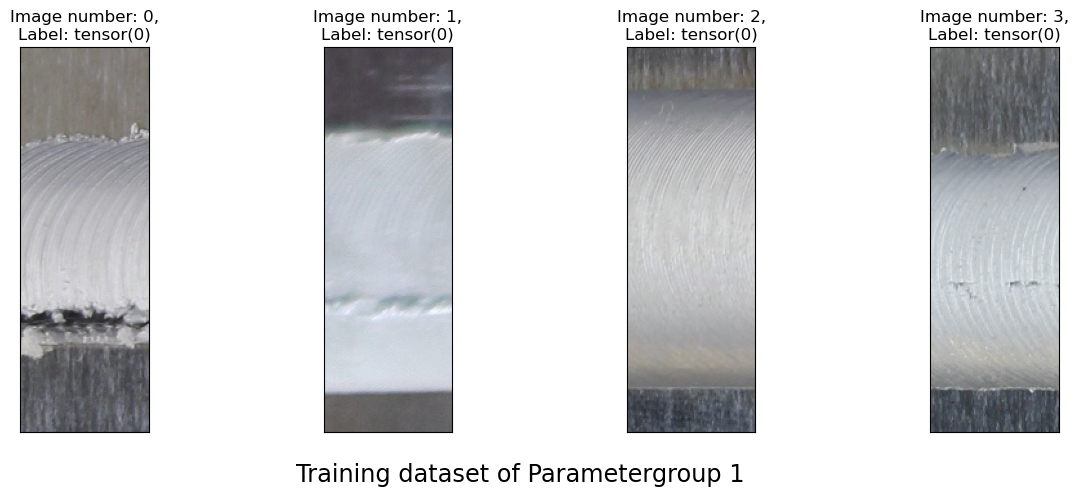

In [136]:
# Show the dataset in comparison -> just to see if the dataset is correct

# Number of the parametergroup to be shown (1-7) -> 0 = parametergroup 1, 1 = parametergroup 2, ...
group_num = 0
# Number of the image to be shown
img_num = 0

print(len(classification_datasets_train[group_num]))

# Show the first four images in one row
fig, axs = plt.subplots(1, 4)

# Show the first image of the training dataset
axs[0].imshow(classification_datasets_train[group_num][img_num][0].permute(1, 2, 0))
# Add a title to the first image
axs[0].set_title("Image number: "+str(img_num) + ",\nLabel: " + str(classification_datasets_train[group_num][img_num][1]))
# Show the first image of the regular training dataset
axs[1].imshow(classification_datasets_train[group_num][img_num+1][0].permute(1, 2, 0))
# Add a title to the first image
axs[1].set_title("Image number: "+str(img_num+1) + ",\nLabel: " + str(classification_datasets_train[group_num][img_num+1][1]))
# Show the first image of the regular training dataset
axs[2].imshow(classification_datasets_train[group_num][img_num+2][0].permute(1, 2, 0))
# Add a title to the first image
axs[2].set_title("Image number: "+str(img_num+2) + ",\nLabel: " + str(classification_datasets_train[group_num][img_num+2][1]))
# Show the first image of the regular training dataset
axs[3].imshow(classification_datasets_train[group_num][img_num+3][0].permute(1, 2, 0))
# Add a title to the first image
axs[3].set_title("Image number: "+str(img_num+3) + ",\nLabel: " + str(classification_datasets_train[group_num][img_num+3][1]))

# Change layout of the figure
# Add title to the bottom of the figure
fig.suptitle("Training dataset of Parametergroup " + str(group_num+1), x=0.5, y=0.05, ha='center', fontsize='xx-large')
# Increase the size of the figure
fig.set_figheight(5)
# Increase the size of the suplots
fig.set_figwidth(15)
# Decrease the size of the titles
plt.rcParams.update({'font.size': 10})
# Delete the tick marks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Avalanche Benchmark aus den 7 Parametergruppen erstellen (dabei Data Augmentation anwenden)

In [137]:
# Prepare Data Augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3)
])

In [138]:
# Create a dataset_benchmark using a generic benchmark generator

generic_scenario = dataset_benchmark(train_datasets=classification_datasets_train[:],      # using the combined training datasets which contain regular and augmented images
                                     test_datasets=classification_datasets_test[:],
                                     train_transform=train_transform,                      # apply data augmentation to the training datasets
                                     eval_transform=None,
                                     )

train_stream = generic_scenario.train_stream
test_stream = generic_scenario.test_stream

for experience in train_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    training_dataset = experience.dataset
    print('Task {}, Experience ID {} -> train'.format(t, exp_id))
    print('This task contains', len(training_dataset), 'images')
    print('Classes in this task:', experience.classes_in_this_experience)
    print("")

print("")
print("")
for experience in test_stream:
    t = experience.task_label
    exp_id = experience.current_experience
    test_dataset = experience.dataset
    print('Task {}, Experience ID {} -> test'.format(t, exp_id))
    print('This task contains', len(test_dataset), 'images')
    print('Classes in this task:', experience.classes_in_this_experience)
    print("")

Task 1, Experience ID 0 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 2, Experience ID 1 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 3, Experience ID 2 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 4, Experience ID 3 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 5, Experience ID 4 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 6, Experience ID 5 -> train
This task contains 686 images
Classes in this task: [0, 1]

Task 7, Experience ID 6 -> train
This task contains 686 images
Classes in this task: [0, 1]



Task 1, Experience ID 0 -> test
This task contains 172 images
Classes in this task: [0, 1]

Task 2, Experience ID 1 -> test
This task contains 172 images
Classes in this task: [0, 1]

Task 3, Experience ID 2 -> test
This task contains 172 images
Classes in this task: [0, 1]

Task 4, Experience ID 3 -> test
This task contains 172 images
Classes i

In [139]:
# Just to check if creating the benchmark worked correctly
# Print the datatype and the shape of the data in the train_stream
for i in range(len(train_stream)):
    print("train_stream[",i,"].dataset[0][0].dtype:", train_stream[i].dataset[0][0].dtype)
    print("train_stream[",i,"].dataset[0][0].shape:", train_stream[i].dataset[0][0].shape)
    for j in range(1,3):
        print("train_stream[",i,"].dataset[0][",j,"]:", train_stream[i].dataset[0][j])
    print("")

train_stream[ 0 ].dataset[0][0].dtype: torch.float32
train_stream[ 0 ].dataset[0][0].shape: torch.Size([3, 300, 100])
train_stream[ 0 ].dataset[0][ 1 ]: tensor(0)
train_stream[ 0 ].dataset[0][ 2 ]: 1

train_stream[ 1 ].dataset[0][0].dtype: torch.float32
train_stream[ 1 ].dataset[0][0].shape: torch.Size([3, 300, 100])
train_stream[ 1 ].dataset[0][ 1 ]: tensor(0)
train_stream[ 1 ].dataset[0][ 2 ]: 2

train_stream[ 2 ].dataset[0][0].dtype: torch.float32
train_stream[ 2 ].dataset[0][0].shape: torch.Size([3, 300, 100])
train_stream[ 2 ].dataset[0][ 1 ]: tensor(0)
train_stream[ 2 ].dataset[0][ 2 ]: 3

train_stream[ 3 ].dataset[0][0].dtype: torch.float32
train_stream[ 3 ].dataset[0][0].shape: torch.Size([3, 300, 100])
train_stream[ 3 ].dataset[0][ 1 ]: tensor(1)
train_stream[ 3 ].dataset[0][ 2 ]: 4

train_stream[ 4 ].dataset[0][0].dtype: torch.float32
train_stream[ 4 ].dataset[0][0].shape: torch.Size([3, 300, 100])
train_stream[ 4 ].dataset[0][ 1 ]: tensor(1)
train_stream[ 4 ].dataset[0][ 2 ]

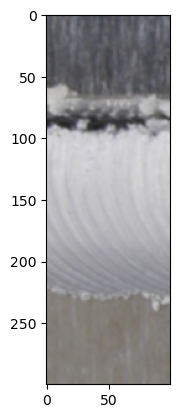

686


In [140]:
# Just to check if creating the benchmark worked correctly
# Show an image of one of the seven tasks in the train_stream to display the data augmentation
plt.imshow(train_stream[0].dataset[0][0].permute(1, 2, 0))
plt.show()
# Print the number of images of one of the seven tasks in the train_stream
print(len(train_stream[0].dataset))

# Avalanche Evaluation Plugin and Loggers initialisieren

In [141]:
# Prepare logger
interactive_logger = InteractiveLogger()

# Prepare evaluation
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=True, stream=False), # set epoch to True to see the accuracy during training, set experience to True to see the accuracy on each dataset
    #loss_metrics,
    #forgetting_metrics(experience=True, stream=False),
    #forward_transfer_metrics,
    #images_samples_metrics,
    #StreamAccuracy,
    #StreamConfusionMatrix,
    loggers=[interactive_logger])

# Speicher-Modalitäten festlegen

In [142]:
# Prepare saving of results
save = True             # set to True to save the results   
date = "2023-11-10"
try_number = 1
data_percentage = 100

# Hyperparameter für die verschiedenen Trainingsstrategien einstellen

In [143]:
# Hyperparameter for Naive Finetuning
epochs_Naive = 10
batch_size_Naive = 16
learning_rate_Naive = 1e-4

In [144]:
# Hyperparameter for EWC
# Deep Learning Hyperparameter
epochs_EWC = 25
batch_size_EWC = 16
learning_rate_EWC = 1e-5
# Continual Learning Hyperparameter
lambda_EWC = 10000     # hyperparameter to weigh the penalty inside the total loss -> The larger the lambda, the larger the regularization
mode_EWC = 'online'      # onlinesum to keep a single penalty summed over all previous tasks -> Online EWC
decay_factor_EWC = 1.0   # specifies the decay term of the importance matrix

In [145]:
# Hyperparameter for MAS
# Deep Learning Hyperparameter
epochs_MAS = 20
batch_size_MAS = 16
learning_rate_MAS = 1e-5
# Continual Learning Hyperparameter
lambda_MAS = 5          # hyperparameter weighting the penalty term in the overall loss
alpha_MAS = 0.5             # hyperparameter that specifies the weight given to the influence of the previous experience (called gamma in my thesis)

# ResNet18 laden

In [146]:
model = models.resnet18(weights=True)                               # load resnet18 model with pretrained weights
num_features = model.fc.in_features                                 # extract fc layers features
model.fc = nn.Linear(num_features, 2)                               # num_of_class == 2
model = model.to(device, dtype=torch.float32)                       # dtype adapted to float32
criterion = nn.CrossEntropyLoss()                                   # set loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate_Naive)  # set optimizer

c:\Users\JanHe\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [147]:
# Check the datatype of the weights of the model (for debugging) -> should be float32
print(model.conv1.weight.dtype)

torch.float32


# Training

## Model auf erster Parametergruppe mit Naive Finetuning trainieren

In [148]:
# Define the Continual Learning Strategy
cl_strategy_Naive_Pre = Naive(model,        # no deepcopy of the model -> weights should be adapted to the first task before Continual Learning starts
                    optimizer,
                    criterion,
                    train_mb_size=batch_size_Naive,
                    train_epochs=epochs_Naive,                       
                    eval_mb_size=batch_size_Naive,
                    evaluator=eval_plugin,
                    eval_every=-1,  # set to -1 to disable the evaluation
                    device=device)

print("TRAINING THE MODEL WITH FINETUNING FOR THE FIRST PARAMETERGROUP\n")

# Create empty lists for the results
train_results_list_NAIVE = []
test_results_list_NAIVE = []
train_results_list_EWC = []
test_results_list_EWC = []
train_results_list_MAS = []
test_results_list_MAS = []

# Train and test loop (Naive Finetuning: Parametergroup 1)
experience = train_stream[0]
print("###################################### Start training the model on experience", experience.current_experience,"######################################")
train_results_Naive_Pre = cl_strategy_Naive_Pre.train(experience)
train_results_list_NAIVE.append(train_results_Naive_Pre)
train_results_list_EWC.append(train_results_Naive_Pre)
train_results_list_MAS.append(train_results_Naive_Pre)
print("###################################### Training the model on experience", experience.current_experience, "completed ######################################\n")
    
print("###################################### Start evaluating the on experience", experience.current_experience,"trained model ######################################")
test_results_Naive_Pre = cl_strategy_Naive_Pre.eval(test_stream)
test_results_list_NAIVE.append(test_results_Naive_Pre)
test_results_list_EWC.append(test_results_Naive_Pre)
test_results_list_MAS.append(test_results_Naive_Pre)
print("###################################### Evaluating the on experience", experience.current_experience, "trained model completed ######################################\n")

# Output final results
print("length of train results list:", len(train_results_list_NAIVE), "; train results list: ", train_results_list_NAIVE)
print("length of test results list:", len(test_results_list_NAIVE), "; test results list: ", test_results_list_NAIVE)

TRAINING THE MODEL WITH FINETUNING FOR THE FIRST PARAMETERGROUP

###################################### Start training the model on experience 0 ######################################
-- >> Start of training phase << --
100%|██████████| 43/43 [00:02<00:00, 20.32it/s]
Epoch 0 ended.
-- >> End of training phase << --
###################################### Training the model on experience 0 completed ######################################

###################################### Start evaluating the on experience 0 trained model ######################################
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 1) from test stream --
100%|██████████| 11/11 [00:00<00:00, 52.34it/s]
> Eval on experience 0 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000 = 0.9651
-- Starting eval on experience 1 (Task 2) from test stream --
100%|██████████| 11/11 [00:00<00:00, 55.46it/s]
> Eval on experience 1 (Task 2) from test stream ended.
	Top1

# Methode 1: Naive Finetuning
## Kein Continual Learning
### Base accuracy (Task der gerade trainiert wurde) testen
### General accuracy (Tasks die nicht gerade trainiert wurden) testen

In [149]:
# Define the Continual Learning Strategy
cl_strategy_Naive = Naive(copy.deepcopy(model),
                    optimizer,
                    criterion,
                    train_mb_size=batch_size_Naive,
                    train_epochs=epochs_Naive,                       
                    eval_mb_size=batch_size_Naive,
                    evaluator=eval_plugin,
                    eval_every=-1,  # set to -1 to disable the evaluation
                    device=device)

print("TRAINING THE MODEL WITH FINETUNING -> NO MITIGATION OF CATASTROPHIC FORGETTING\n")

# Train and test loop
for experience in train_stream[1:7]:
    print("###################################### Start training the model on experience", experience.current_experience,"######################################")
    train_results_Naive = cl_strategy_Naive.train(experience)
    train_results_list_NAIVE.append(train_results_Naive)
    print("###################################### Training the model on experience", experience.current_experience, "completed ######################################\n")
    
    print("###################################### Start evaluating the on experience", experience.current_experience,"trained model ######################################")
    test_results_Naive = cl_strategy_Naive.eval(test_stream)
    test_results_list_NAIVE.append(test_results_Naive)
    print("###################################### Evaluating the on experience", experience.current_experience, "trained model completed ######################################\n")

# Output final results
print("length of train results list:", len(train_results_list_NAIVE), "; train results list: ", train_results_list_NAIVE)
print("length of test results list:", len(test_results_list_NAIVE), "; test results list: ", test_results_list_NAIVE)

TRAINING THE MODEL WITH FINETUNING -> NO MITIGATION OF CATASTROPHIC FORGETTING

###################################### Start training the model on experience 1 ######################################
-- >> Start of training phase << --
100%|██████████| 43/43 [00:02<00:00, 20.02it/s]
Epoch 0 ended.
-- >> End of training phase << --
###################################### Training the model on experience 1 completed ######################################

###################################### Start evaluating the on experience 1 trained model ######################################
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 1) from test stream --
100%|██████████| 11/11 [00:00<00:00, 51.05it/s]
> Eval on experience 0 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000 = 0.8953
-- Starting eval on experience 1 (Task 2) from test stream --
100%|██████████| 11/11 [00:00<00:00, 55.99it/s]
> Eval on experience 1 (Task 2) from test stre

In [150]:
metric_dict_Naive = eval_plugin.get_all_metrics()
print("metric dictionary:\n")
metric_dict_Naive

metric dictionary:



defaultdict(<function avalanche.training.plugins.evaluation.EvaluationPlugin.__init__.<locals>.<lambda>()>,
            {'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000': ([43,
               43,
               86,
               129,
               172,
               215,
               258],
              [0.9651162790697675,
               0.8953488372093024,
               0.8313953488372093,
               0.7267441860465116,
               0.7848837209302325,
               0.7558139534883721,
               0.7093023255813954]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp001': ([43,
               43,
               86,
               129,
               172,
               215,
               258],
              [0.8313953488372093,
               1.0,
               0.8023255813953488,
               0.7441860465116279,
               0.7906976744186046,
               0.936046511627907,
               0.9302325581395349]),
             'Top1_Acc_Exp/eva

In [151]:
""" df_forgetting_Naive = pd.DataFrame()

# Extract and print the values which contain the ExperienceForgetting metric
for key, value in metric_dict_Naive.items():
    if type(key)!=int and 'ExperienceForgetting' in key:
        forgetting_list = value[1]
        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(forgetting_list)):
            df_forgetting_Naive.loc[i, key] = forgetting_list[i]

df_forgetting_Naive """

" df_forgetting_Naive = pd.DataFrame()\n\n# Extract and print the values which contain the ExperienceForgetting metric\nfor key, value in metric_dict_Naive.items():\n    if type(key)!=int and 'ExperienceForgetting' in key:\n        forgetting_list = value[1]\n        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(forgetting_list)):\n            df_forgetting_Naive.loc[i, key] = forgetting_list[i]\n\ndf_forgetting_Naive "

In [152]:
""" df_accuracy_Naive = pd.DataFrame()

# Extract and print the values which contain the accuracy metric for the evaluation on the test stream
for key, value in metric_dict_Naive.items():
    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:
        accuracy_list = value[1]
        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(accuracy_list)):
            df_accuracy_Naive.loc[i, key] = accuracy_list[i]

df_accuracy_Naive """

" df_accuracy_Naive = pd.DataFrame()\n\n# Extract and print the values which contain the accuracy metric for the evaluation on the test stream\nfor key, value in metric_dict_Naive.items():\n    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:\n        accuracy_list = value[1]\n        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(accuracy_list)):\n            df_accuracy_Naive.loc[i, key] = accuracy_list[i]\n\ndf_accuracy_Naive "

In [153]:
""" df_forgetting_shifted_Naive = pd.DataFrame()

# Shift the values in each column downwards based on the number of NaN values in that row
# -> Now the values in each row are the forgetting values of the corresponding experience
for col in df_forgetting_Naive.columns:
    n_shifts = df_forgetting_Naive[col].isna().sum()
    df_forgetting_shifted_Naive[col] = df_forgetting_Naive[col].shift(n_shifts)
    df_forgetting_shifted_Naive.loc[:n_shifts-2, col] = np.nan

df_forgetting_shifted_Naive """

' df_forgetting_shifted_Naive = pd.DataFrame()\n\n# Shift the values in each column downwards based on the number of NaN values in that row\n# -> Now the values in each row are the forgetting values of the corresponding experience\nfor col in df_forgetting_Naive.columns:\n    n_shifts = df_forgetting_Naive[col].isna().sum()\n    df_forgetting_shifted_Naive[col] = df_forgetting_Naive[col].shift(n_shifts)\n    df_forgetting_shifted_Naive.loc[:n_shifts-2, col] = np.nan\n\ndf_forgetting_shifted_Naive '

In [154]:
""" # Calculate the overall mean forgetting
df_forgetting_shifted_series_Naive = df_forgetting_shifted_Naive.stack()
#print(df_forgetting_shifted_series)

mean_forgetting_Naive = df_forgetting_shifted_series_Naive.mean()
print("Mean forgetting:", mean_forgetting_Naive) """

' # Calculate the overall mean forgetting\ndf_forgetting_shifted_series_Naive = df_forgetting_shifted_Naive.stack()\n#print(df_forgetting_shifted_series)\n\nmean_forgetting_Naive = df_forgetting_shifted_series_Naive.mean()\nprint("Mean forgetting:", mean_forgetting_Naive) '

In [155]:
""" # Calculate the overall mean accuracy
df_accuracy_series_Naive = df_accuracy_Naive.stack()
#print(df_accuracy_series)

mean_accuracy_Naive = df_accuracy_series_Naive.mean()
print("Mean accuracy:", mean_accuracy_Naive) """

' # Calculate the overall mean accuracy\ndf_accuracy_series_Naive = df_accuracy_Naive.stack()\n#print(df_accuracy_series)\n\nmean_accuracy_Naive = df_accuracy_series_Naive.mean()\nprint("Mean accuracy:", mean_accuracy_Naive) '

In [156]:
""" # Calculate the mean forgetting for each parameter group
df_forgetting_mean_Naive = df_forgetting_shifted_Naive
df_forgetting_mean_Naive.loc['mean'] = df_forgetting_shifted_Naive.mean(axis=0)

df_forgetting_mean_Naive """

" # Calculate the mean forgetting for each parameter group\ndf_forgetting_mean_Naive = df_forgetting_shifted_Naive\ndf_forgetting_mean_Naive.loc['mean'] = df_forgetting_shifted_Naive.mean(axis=0)\n\ndf_forgetting_mean_Naive "

In [157]:
""" # Calculate the mean accuracy for each parameter group
df_accuracy_mean_Naive = df_accuracy_Naive
df_accuracy_mean_Naive.loc['mean'] = df_accuracy_Naive.mean(axis=0)

df_accuracy_mean_Naive """

" # Calculate the mean accuracy for each parameter group\ndf_accuracy_mean_Naive = df_accuracy_Naive\ndf_accuracy_mean_Naive.loc['mean'] = df_accuracy_Naive.mean(axis=0)\n\ndf_accuracy_mean_Naive "

In [158]:
""" print(len(test_results_list_NAIVE))
test_results_list_NAIVE """

' print(len(test_results_list_NAIVE))\ntest_results_list_NAIVE '

In [159]:
# Create a 7x7 numpy array out of the test_results_list
test_results_values_NAIVE = [value for item in test_results_list_NAIVE for value in item.values()]

test_results_array_NAIVE = np.array(test_results_values_NAIVE).reshape(7,7)

# Save the results as a numpy array in the results folder
if save == True:
    np.save('../results/Numpy_Arrays/NumpyArray_Naive_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.npy', test_results_array_NAIVE)

test_results_array_NAIVE

array([[0.96511628, 0.83139535, 0.63372093, 0.47674419, 0.75581395,
        0.85465116, 0.87209302],
       [0.89534884, 1.        , 0.71511628, 0.63372093, 0.81395349,
        0.77906977, 0.89534884],
       [0.83139535, 0.80232558, 0.97093023, 0.65697674, 0.85465116,
        0.75581395, 0.69767442],
       [0.72674419, 0.74418605, 0.8372093 , 0.98255814, 0.86046512,
        0.75      , 0.80813953],
       [0.78488372, 0.79069767, 0.88372093, 0.96511628, 0.96511628,
        0.85465116, 0.87209302],
       [0.75581395, 0.93604651, 0.9127907 , 0.88953488, 0.93023256,
        0.97674419, 0.9127907 ],
       [0.70930233, 0.93023256, 0.83139535, 0.6744186 , 0.9244186 ,
        0.94186047, 0.94767442]])

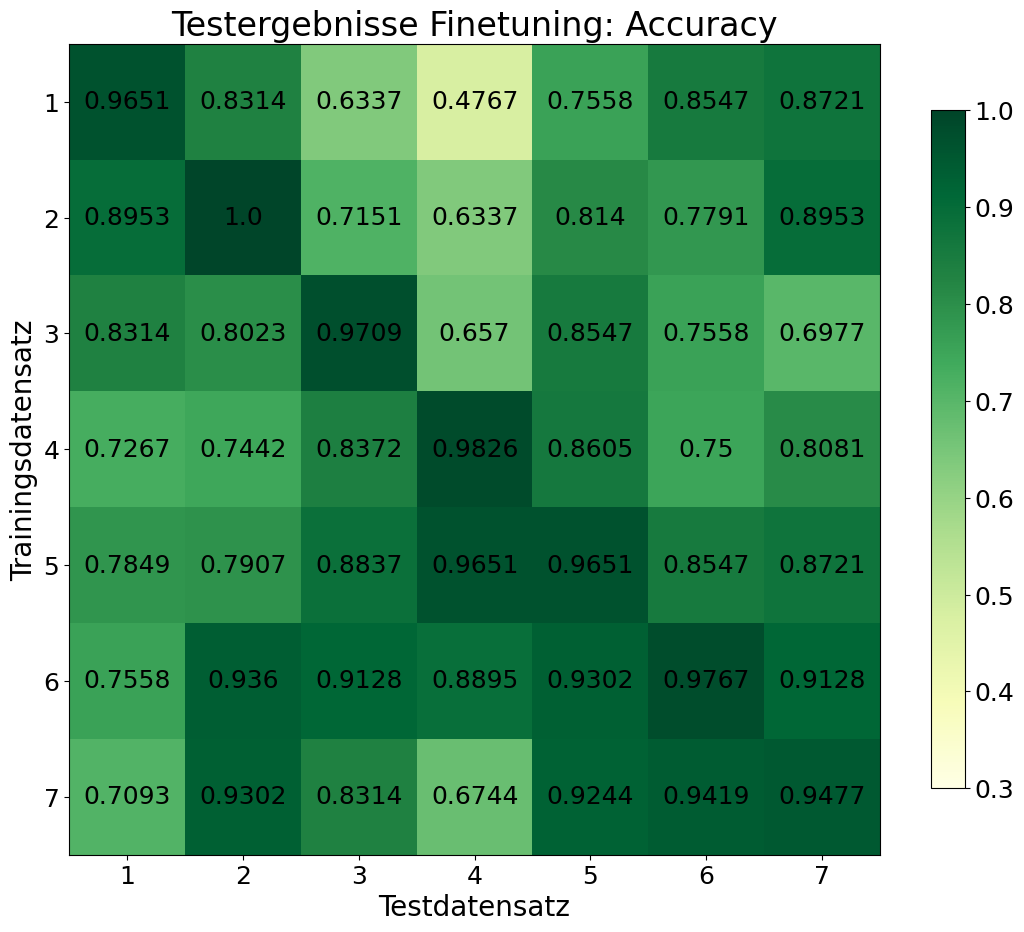

In [160]:
# Plot the test results

# Determine the common color scale range for the colorbar
vmin = 0.3
vmax = 1.0

fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(test_results_array_NAIVE, cmap="YlGn", vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_yticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_xlabel("Testdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax.set_ylabel("Trainingsdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
title = ax.set_title("Testergebnisse Finetuning: Accuracy", fontdict={'fontsize': 24, 'fontweight': 'medium'})
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, round(test_results_array_NAIVE[i, j], 4), ha="center", va="center", color="black", fontdict={'fontsize': 18, 'fontweight': 'medium'})
fig.tight_layout()

# Add a colorbar with the same color scale
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.7)
cbar.set_ticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.yaxis.set_tick_params(labelsize=18)                         # Increase the size of the colorbar ticks
cbar.set_ticklabels([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.show()

# Save the plot in the results folder
if save == True:
    fig.savefig('../results/Heatmaps/Heatmap_Naive_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.png')

In [161]:
""" # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets
parameter_group = 5     # choose the parameter group    

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1,8), test_results_array_NAIVE[parameter_group-1,:], marker="o", color= "gray")
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy des Modells trainiert mit Naive Finetuning auf Parametergruppe " + str(parameter_group))
plt.show() """

' # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets\nparameter_group = 5     # choose the parameter group    \n\nfig, ax = plt.subplots(figsize=(15,10))\nax.plot(range(1,8), test_results_array_NAIVE[parameter_group-1,:], marker="o", color= "gray")\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Accuracy des Modells trainiert mit Naive Finetuning auf Parametergruppe " + str(parameter_group))\nplt.show() '

In [162]:
""" # Plot the accuracy of each model trained on a parameter group over all seven test datasets
fig, ax = plt.subplots(figsize=(15,10))
for i in range(7):
    ax.plot(range(1,8), test_results_array_NAIVE[i,:], marker="o", label="Parametergruppe " + str(i+1))
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Verlauf der Accuracy der Modelle trainiert mit Naive Finetuning auf den Parametergruppen 1-7")
ax.legend(bbox_to_anchor=(1, 0.2))
plt.show() """

' # Plot the accuracy of each model trained on a parameter group over all seven test datasets\nfig, ax = plt.subplots(figsize=(15,10))\nfor i in range(7):\n    ax.plot(range(1,8), test_results_array_NAIVE[i,:], marker="o", label="Parametergruppe " + str(i+1))\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Verlauf der Accuracy der Modelle trainiert mit Naive Finetuning auf den Parametergruppen 1-7")\nax.legend(bbox_to_anchor=(1, 0.2))\nplt.show() '

# Methode 2: EWC
## Continual Learning
### Continual Learning backward accuracy (Tasks die bereits trainiert wurden) testen
### Continual Learning forward accuracy (Tasks die noch nicht trainiert wurden) testen

In [163]:
optimizer_EWC = optim.Adam(model.parameters(), lr=learning_rate_EWC)  # set optimizer to use the EWC learning rate

# Define the Continual Learning Strategy
cl_strategy_EWC = EWC(copy.deepcopy(model),
                    optimizer_EWC,
                    criterion,
                    train_mb_size=batch_size_EWC,
                    train_epochs=epochs_EWC,                       
                    eval_mb_size=batch_size_EWC,
                    evaluator=eval_plugin,
                    eval_every=-1,  # set to -1 to disable the evaluation
                    device=device,
                    ewc_lambda=lambda_EWC,
                    mode=mode_EWC,
                    decay_factor=decay_factor_EWC
                    )

print("TRAINING THE MODEL WITH ELASTIC WEIGHT CONSOLIDATION (EWC) -> MITIGATION OF CATASTROPHIC FORGETTING\n")

# Train and test loop (EWC: Parametergruppe 2 - 7)
for experience in train_stream[1:7]:
    print("###################################### Start training the model on experience", experience.current_experience,"######################################")
    train_results_EWC = cl_strategy_EWC.train(experience)
    train_results_list_EWC.append(train_results_EWC)
    print("###################################### Training the model on experience", experience.current_experience, "completed ######################################\n")
    
    print("###################################### Start evaluating the on experience", experience.current_experience,"trained model ######################################")
    test_results_EWC = cl_strategy_EWC.eval(test_stream)
    test_results_list_EWC.append(test_results_EWC)
    print("###################################### Evaluating the on experience", experience.current_experience, "trained model completed ######################################\n")

# Output final results
print("length of train results list:", len(train_results_list_EWC), "; train results list: ", train_results_list_EWC)
print("length of test results list:", len(test_results_list_EWC), "; test results list: ", test_results_list_EWC)

TRAINING THE MODEL WITH ELASTIC WEIGHT CONSOLIDATION (EWC) -> MITIGATION OF CATASTROPHIC FORGETTING

###################################### Start training the model on experience 1 ######################################
-- >> Start of training phase << --
100%|██████████| 43/43 [00:02<00:00, 19.70it/s]
Epoch 0 ended.
-- >> End of training phase << --
###################################### Training the model on experience 1 completed ######################################

###################################### Start evaluating the on experience 1 trained model ######################################
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 1) from test stream --
100%|██████████| 11/11 [00:00<00:00, 51.18it/s]
> Eval on experience 0 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000 = 0.9535
-- Starting eval on experience 1 (Task 2) from test stream --
100%|██████████| 11/11 [00:00<00:00, 54.70it/s]
> Eval on experience 1 (T

In [164]:
metric_dict_EWC = eval_plugin.get_all_metrics()
print("metric dictionary:\n")
metric_dict_EWC

metric dictionary:



defaultdict(<function avalanche.training.plugins.evaluation.EvaluationPlugin.__init__.<locals>.<lambda>()>,
            {'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000': ([43,
               43,
               86,
               129,
               172,
               215,
               258,
               43,
               86,
               129,
               172,
               215,
               258],
              [0.9651162790697675,
               0.8953488372093024,
               0.8313953488372093,
               0.7267441860465116,
               0.7848837209302325,
               0.7558139534883721,
               0.7093023255813954,
               0.9534883720930233,
               0.8604651162790697,
               0.8895348837209303,
               0.7674418604651163,
               0.872093023255814,
               0.9011627906976745]),
             'Top1_Acc_Exp/eval_phase/test_stream/Task002/Exp001': ([43,
               43,
               86,
               

In [165]:
""" df_forgetting_EWC = pd.DataFrame()

# Extract and print the values which contain the ExperienceForgetting metric
for key, value in metric_dict_EWC.items():
    if type(key)!=int and 'ExperienceForgetting' in key:
        forgetting_list = value[1]
        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(forgetting_list)):
            df_forgetting_EWC.loc[i, key] = forgetting_list[i]

df_forgetting_EWC """

" df_forgetting_EWC = pd.DataFrame()\n\n# Extract and print the values which contain the ExperienceForgetting metric\nfor key, value in metric_dict_EWC.items():\n    if type(key)!=int and 'ExperienceForgetting' in key:\n        forgetting_list = value[1]\n        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(forgetting_list)):\n            df_forgetting_EWC.loc[i, key] = forgetting_list[i]\n\ndf_forgetting_EWC "

In [166]:
""" df_accuracy_EWC = pd.DataFrame()

# Extract and print the values which contain the accuracy metric for the evaluation on the test stream
for key, value in metric_dict_EWC.items():
    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:
        accuracy_list = value[1]
        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(accuracy_list)):
            df_accuracy_EWC.loc[i, key] = accuracy_list[i]

df_accuracy_EWC """

" df_accuracy_EWC = pd.DataFrame()\n\n# Extract and print the values which contain the accuracy metric for the evaluation on the test stream\nfor key, value in metric_dict_EWC.items():\n    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:\n        accuracy_list = value[1]\n        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(accuracy_list)):\n            df_accuracy_EWC.loc[i, key] = accuracy_list[i]\n\ndf_accuracy_EWC "

In [167]:
""" df_forgetting_shifted_EWC = pd.DataFrame()

# Shift the values in each column downwards based on the number of NaN values in that row
# -> Now the values in each row are the forgetting values of the corresponding experience
for col in df_forgetting_EWC.columns:
    n_shifts = df_forgetting_EWC[col].isna().sum()
    df_forgetting_shifted_EWC[col] = df_forgetting_EWC[col].shift(n_shifts)
    df_forgetting_shifted_EWC.loc[:n_shifts-2, col] = np.nan

df_forgetting_shifted_EWC """

' df_forgetting_shifted_EWC = pd.DataFrame()\n\n# Shift the values in each column downwards based on the number of NaN values in that row\n# -> Now the values in each row are the forgetting values of the corresponding experience\nfor col in df_forgetting_EWC.columns:\n    n_shifts = df_forgetting_EWC[col].isna().sum()\n    df_forgetting_shifted_EWC[col] = df_forgetting_EWC[col].shift(n_shifts)\n    df_forgetting_shifted_EWC.loc[:n_shifts-2, col] = np.nan\n\ndf_forgetting_shifted_EWC '

In [168]:
""" # Calculate the overall mean forgetting
df_forgetting_shifted_series_EWC = df_forgetting_shifted_EWC.stack()
#print(df_forgetting_shifted_series)

mean_forgetting_EWC = df_forgetting_shifted_series_EWC.mean()
print("Mean forgetting:", mean_forgetting_EWC) """

' # Calculate the overall mean forgetting\ndf_forgetting_shifted_series_EWC = df_forgetting_shifted_EWC.stack()\n#print(df_forgetting_shifted_series)\n\nmean_forgetting_EWC = df_forgetting_shifted_series_EWC.mean()\nprint("Mean forgetting:", mean_forgetting_EWC) '

In [169]:
""" # Calculate the overall mean accuracy
df_accuracy_series_EWC = df_accuracy_EWC.stack()
#print(df_accuracy_series)

mean_accuracy_EWC = df_accuracy_series_EWC.mean()
print("Mean accuracy:", mean_accuracy_EWC) """

' # Calculate the overall mean accuracy\ndf_accuracy_series_EWC = df_accuracy_EWC.stack()\n#print(df_accuracy_series)\n\nmean_accuracy_EWC = df_accuracy_series_EWC.mean()\nprint("Mean accuracy:", mean_accuracy_EWC) '

In [170]:
""" # Calculate the mean forgetting for each parameter group
df_forgetting_mean_EWC = df_forgetting_shifted_EWC
df_forgetting_mean_EWC.loc['mean'] = df_forgetting_shifted_EWC.mean(axis=0)

df_forgetting_mean_EWC """

" # Calculate the mean forgetting for each parameter group\ndf_forgetting_mean_EWC = df_forgetting_shifted_EWC\ndf_forgetting_mean_EWC.loc['mean'] = df_forgetting_shifted_EWC.mean(axis=0)\n\ndf_forgetting_mean_EWC "

In [171]:
""" # Calculate the mean accuracy for each parameter group
df_accuracy_mean_EWC = df_accuracy_EWC
df_accuracy_mean_EWC.loc['mean'] = df_accuracy_EWC.mean(axis=0)

df_accuracy_mean_EWC """

" # Calculate the mean accuracy for each parameter group\ndf_accuracy_mean_EWC = df_accuracy_EWC\ndf_accuracy_mean_EWC.loc['mean'] = df_accuracy_EWC.mean(axis=0)\n\ndf_accuracy_mean_EWC "

In [172]:
# Create a 7x7 numpy array out of the test_results_list
test_results_values_EWC = [value for item in test_results_list_EWC for value in item.values()]

test_results_array_EWC = np.array(test_results_values_EWC).reshape(7,7)

# Save the results as a numpy array in the results folder
if save == True:
    np.save('../results/Numpy_Arrays/NumpyArray_EWC_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.npy', test_results_array_EWC)

test_results_array_EWC

array([[0.96511628, 0.83139535, 0.63372093, 0.47674419, 0.75581395,
        0.85465116, 0.87209302],
       [0.95348837, 0.93023256, 0.50581395, 0.52325581, 0.72093023,
        0.81976744, 0.87790698],
       [0.86046512, 0.72674419, 0.58139535, 0.52325581, 0.6744186 ,
        0.64534884, 0.69186047],
       [0.88953488, 0.74418605, 0.73255814, 0.77325581, 0.84883721,
        0.69186047, 0.73255814],
       [0.76744186, 0.60465116, 0.49418605, 0.59302326, 0.70930233,
        0.5755814 , 0.59302326],
       [0.87209302, 0.76744186, 0.77325581, 0.68604651, 0.89534884,
        0.86627907, 0.86627907],
       [0.90116279, 0.83139535, 0.81976744, 0.76162791, 0.9127907 ,
        0.93023256, 0.88953488]])

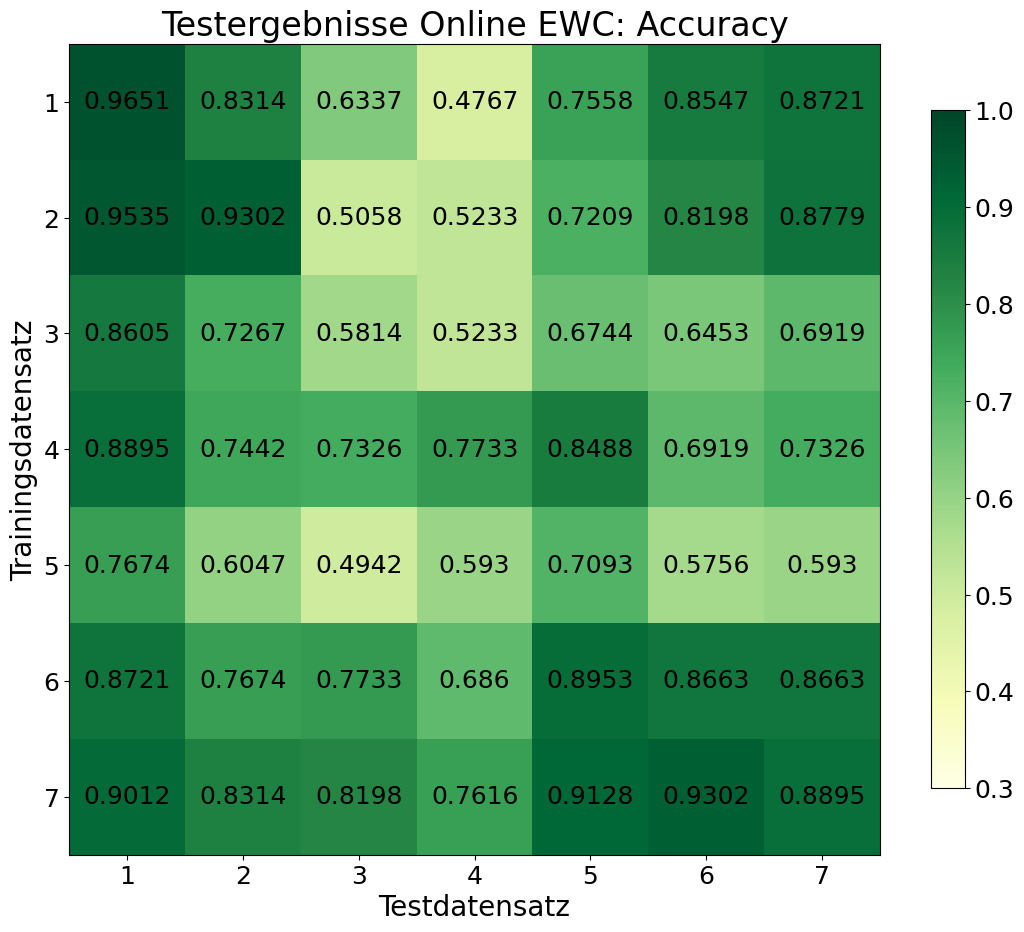

In [173]:
# Plot the test results
fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(test_results_array_EWC, cmap="YlGn", vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_yticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_xlabel("Testdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax.set_ylabel("Trainingsdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
title = ax.set_title("Testergebnisse Online EWC: Accuracy", fontdict={'fontsize': 24, 'fontweight': 'medium'})
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, round(test_results_array_EWC[i, j], 4), ha="center", va="center", color="black", fontdict={'fontsize': 18, 'fontweight': 'medium'})
fig.tight_layout()

# Add a colorbar with the same color scale
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.7)
cbar.set_ticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.yaxis.set_tick_params(labelsize=18)                         # Increase the size of the colorbar ticks
cbar.set_ticklabels([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.show()

# Save the plot in the results folder
if save == True:
    fig.savefig('../results/Heatmaps/Heatmap_EWC_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.png')

In [174]:
""" # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets
parameter_group = 5     # choose the parameter group    

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1,8), test_results_array_EWC[parameter_group-1,:], marker="o", color= "gray")
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy des Modells trainiert mit EWC auf Parametergruppe " + str(parameter_group))
plt.show() """

' # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets\nparameter_group = 5     # choose the parameter group    \n\nfig, ax = plt.subplots(figsize=(15,10))\nax.plot(range(1,8), test_results_array_EWC[parameter_group-1,:], marker="o", color= "gray")\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Accuracy des Modells trainiert mit EWC auf Parametergruppe " + str(parameter_group))\nplt.show() '

In [175]:
""" # Plot the accuracy of each model trained on a parameter group over all seven test datasets
fig, ax = plt.subplots(figsize=(15,10))
for i in range(7):
    ax.plot(range(1,8), test_results_array_EWC[i,:], marker="o", label="Parametergruppe " + str(i+1))
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Verlauf der Accuracy der Modelle trainiert mit EWC auf den Parametergruppen 1-7")
ax.legend(bbox_to_anchor=(1, 0.2))
plt.show() """

' # Plot the accuracy of each model trained on a parameter group over all seven test datasets\nfig, ax = plt.subplots(figsize=(15,10))\nfor i in range(7):\n    ax.plot(range(1,8), test_results_array_EWC[i,:], marker="o", label="Parametergruppe " + str(i+1))\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Verlauf der Accuracy der Modelle trainiert mit EWC auf den Parametergruppen 1-7")\nax.legend(bbox_to_anchor=(1, 0.2))\nplt.show() '

# Methode 3: MAS
## Continual Learning
### Continual Learning backward accuracy (Tasks die bereits trainiert wurden) testen
### Continual Learning forward accuracy (Tasks die noch nicht trainiert wurden) testen

In [176]:
optimizer_MAS = optim.Adam(model.parameters(), lr=learning_rate_MAS)  # set optimizer to use the MAS learning rate

# Define the Continual Learning Strategy
cl_strategy_MAS = MAS(copy.deepcopy(model),
                    optimizer_MAS,
                    criterion,
                    train_mb_size=batch_size_MAS,
                    train_epochs=epochs_MAS,                       
                    eval_mb_size=batch_size_MAS,
                    evaluator=eval_plugin,
                    eval_every=-1,  # set to -1 to disable the evaluation
                    device=device,
                    lambda_reg=lambda_MAS,
                    alpha=alpha_MAS
                    )

print("TRAINING THE MODEL WITH MEMORY AWARE SYNAPSES (MAS) -> MITIGATION OF CATASTROPHIC FORGETTING\n")

# Train and test loop (MAS: Parametergruppe 2 - 7)
for experience in train_stream[1:7]:
    print("###################################### Start training the model on experience", experience.current_experience,"######################################")
    train_results_MAS = cl_strategy_MAS.train(experience)
    train_results_list_MAS.append(train_results_MAS)
    print("###################################### Training the model on experience", experience.current_experience, "completed ######################################\n")
    
    print("###################################### Start evaluating the on experience", experience.current_experience,"trained model ######################################")
    test_results_MAS = cl_strategy_MAS.eval(test_stream)
    test_results_list_MAS.append(test_results_MAS)
    print("###################################### Evaluating the on experience", experience.current_experience, "trained model completed ######################################\n")

# Output final results
print("length of train results list:", len(train_results_list_MAS), "; train results list: ", train_results_list_MAS)
print("length of test results list:", len(test_results_list_MAS), "; test results list: ", test_results_list_MAS)

TRAINING THE MODEL WITH MEMORY AWARE SYNAPSES (MAS) -> MITIGATION OF CATASTROPHIC FORGETTING

###################################### Start training the model on experience 1 ######################################
-- >> Start of training phase << --
100%|██████████| 43/43 [00:02<00:00, 19.73it/s]
Epoch 0 ended.
-- >> End of training phase << --
###################################### Training the model on experience 1 completed ######################################

###################################### Start evaluating the on experience 1 trained model ######################################
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 1) from test stream --
100%|██████████| 11/11 [00:00<00:00, 50.64it/s]
> Eval on experience 0 (Task 1) from test stream ended.
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000 = 0.9593
-- Starting eval on experience 1 (Task 2) from test stream --
100%|██████████| 11/11 [00:00<00:00, 55.06it/s]
> Eval on experience 1 (Task 2) 

In [177]:
metric_dict_MAS = eval_plugin.get_all_metrics()
print("metric dictionary:\n")
metric_dict_MAS

metric dictionary:



defaultdict(<function avalanche.training.plugins.evaluation.EvaluationPlugin.__init__.<locals>.<lambda>()>,
            {'Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp000': ([43,
               43,
               86,
               129,
               172,
               215,
               258,
               43,
               86,
               129,
               172,
               215,
               258,
               43,
               86,
               129,
               172,
               215,
               258],
              [0.9651162790697675,
               0.8953488372093024,
               0.8313953488372093,
               0.7267441860465116,
               0.7848837209302325,
               0.7558139534883721,
               0.7093023255813954,
               0.9534883720930233,
               0.8604651162790697,
               0.8895348837209303,
               0.7674418604651163,
               0.872093023255814,
               0.9011627906976745,
          

In [178]:
""" df_forgetting_MAS = pd.DataFrame()

# Extract and print the values which contain the ExperienceForgetting metric
for key, value in metric_dict_MAS.items():
    if type(key)!=int and 'ExperienceForgetting' in key:
        forgetting_list = value[1]
        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(forgetting_list)):
            df_forgetting_MAS.loc[i, key] = forgetting_list[i]

df_forgetting_MAS """

" df_forgetting_MAS = pd.DataFrame()\n\n# Extract and print the values which contain the ExperienceForgetting metric\nfor key, value in metric_dict_MAS.items():\n    if type(key)!=int and 'ExperienceForgetting' in key:\n        forgetting_list = value[1]\n        print(f'Key: {key}\nForgetting Values: {forgetting_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(forgetting_list)):\n            df_forgetting_MAS.loc[i, key] = forgetting_list[i]\n\ndf_forgetting_MAS "

In [179]:
""" df_accuracy_MAS = pd.DataFrame()

# Extract and print the values which contain the accuracy metric for the evaluation on the test stream
for key, value in metric_dict_MAS.items():
    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:
        accuracy_list = value[1]
        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')
        # Add the current value of each second list to a pandas dataframe
        for i in range(len(accuracy_list)):
            df_accuracy_MAS.loc[i, key] = accuracy_list[i]

df_accuracy_MAS """

" df_accuracy_MAS = pd.DataFrame()\n\n# Extract and print the values which contain the accuracy metric for the evaluation on the test stream\nfor key, value in metric_dict_MAS.items():\n    if type(key)!=int and 'Top1_Acc_Exp/eval_phase/test_stream/' in key:\n        accuracy_list = value[1]\n        print(f'Key: {key}\nAccuracy Values: {accuracy_list}\n')\n        # Add the current value of each second list to a pandas dataframe\n        for i in range(len(accuracy_list)):\n            df_accuracy_MAS.loc[i, key] = accuracy_list[i]\n\ndf_accuracy_MAS "

In [180]:
""" df_forgetting_shifted_MAS = pd.DataFrame()

# Shift the values in each column downwards based on the number of NaN values in that row
# -> Now the values in each row are the forgetting values of the corresponding experience
for col in df_forgetting_MAS.columns:
    n_shifts = df_forgetting_MAS[col].isna().sum()
    df_forgetting_shifted_MAS[col] = df_forgetting_MAS[col].shift(n_shifts)
    df_forgetting_shifted_MAS.loc[:n_shifts-2, col] = np.nan

df_forgetting_shifted_MAS """

' df_forgetting_shifted_MAS = pd.DataFrame()\n\n# Shift the values in each column downwards based on the number of NaN values in that row\n# -> Now the values in each row are the forgetting values of the corresponding experience\nfor col in df_forgetting_MAS.columns:\n    n_shifts = df_forgetting_MAS[col].isna().sum()\n    df_forgetting_shifted_MAS[col] = df_forgetting_MAS[col].shift(n_shifts)\n    df_forgetting_shifted_MAS.loc[:n_shifts-2, col] = np.nan\n\ndf_forgetting_shifted_MAS '

In [181]:
""" # Calculate the overall mean forgetting
df_forgetting_shifted_series_MAS = df_forgetting_shifted_MAS.stack()
#print(df_forgetting_shifted_series_MAS)

mean_forgetting_MAS = df_forgetting_shifted_series_MAS.mean()
print("Mean forgetting:", mean_forgetting_MAS) """

' # Calculate the overall mean forgetting\ndf_forgetting_shifted_series_MAS = df_forgetting_shifted_MAS.stack()\n#print(df_forgetting_shifted_series_MAS)\n\nmean_forgetting_MAS = df_forgetting_shifted_series_MAS.mean()\nprint("Mean forgetting:", mean_forgetting_MAS) '

In [182]:
""" # Calculate the overall mean accuracy
df_accuracy_series_MAS = df_accuracy_MAS.stack()
#print(df_accuracy_series_MAS)

mean_accuracy_MAS = df_accuracy_series_MAS.mean()
print("Mean accuracy:", mean_accuracy_MAS) """

' # Calculate the overall mean accuracy\ndf_accuracy_series_MAS = df_accuracy_MAS.stack()\n#print(df_accuracy_series_MAS)\n\nmean_accuracy_MAS = df_accuracy_series_MAS.mean()\nprint("Mean accuracy:", mean_accuracy_MAS) '

In [183]:
""" # Calculate the mean forgetting for each parameter group
df_forgetting_mean_MAS = df_forgetting_shifted_MAS
df_forgetting_mean_MAS.loc['mean'] = df_forgetting_shifted_MAS.mean(axis=0)

df_forgetting_mean_MAS """

" # Calculate the mean forgetting for each parameter group\ndf_forgetting_mean_MAS = df_forgetting_shifted_MAS\ndf_forgetting_mean_MAS.loc['mean'] = df_forgetting_shifted_MAS.mean(axis=0)\n\ndf_forgetting_mean_MAS "

In [184]:
""" # Calculate the mean accuracy for each parameter group
df_accuracy_mean_MAS = df_accuracy_MAS
df_accuracy_mean_MAS.loc['mean'] = df_accuracy_MAS.mean(axis=0)

df_accuracy_mean_MAS """

" # Calculate the mean accuracy for each parameter group\ndf_accuracy_mean_MAS = df_accuracy_MAS\ndf_accuracy_mean_MAS.loc['mean'] = df_accuracy_MAS.mean(axis=0)\n\ndf_accuracy_mean_MAS "

In [185]:
""" print(len(test_results_list_MAS))
test_results_list_MAS """

' print(len(test_results_list_MAS))\ntest_results_list_MAS '

In [186]:
# Create a 7x7 numpy array out of the test_results_list
test_results_values_MAS = [value for item in test_results_list_MAS for value in item.values()]

test_results_array_MAS = np.array(test_results_values_MAS).reshape(7,7)

# Save the results as a numpy array in the results folder
if save == True:
    np.save('../results/Numpy_Arrays/NumpyArray_MAS_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.npy', test_results_array_MAS)

test_results_array_MAS

array([[0.96511628, 0.83139535, 0.63372093, 0.47674419, 0.75581395,
        0.85465116, 0.87209302],
       [0.95930233, 0.90697674, 0.55232558, 0.52325581, 0.71511628,
        0.81395349, 0.87790698],
       [0.86046512, 0.70930233, 0.59883721, 0.54069767, 0.72674419,
        0.61627907, 0.69186047],
       [0.90116279, 0.73837209, 0.71511628, 0.81976744, 0.87790698,
        0.70930233, 0.74418605],
       [0.83139535, 0.62209302, 0.63953488, 0.70930233, 0.79069767,
        0.62209302, 0.70348837],
       [0.9127907 , 0.84883721, 0.86046512, 0.79651163, 0.9127907 ,
        0.94186047, 0.88372093],
       [0.90697674, 0.87790698, 0.8255814 , 0.84302326, 0.9244186 ,
        0.96511628, 0.9244186 ]])

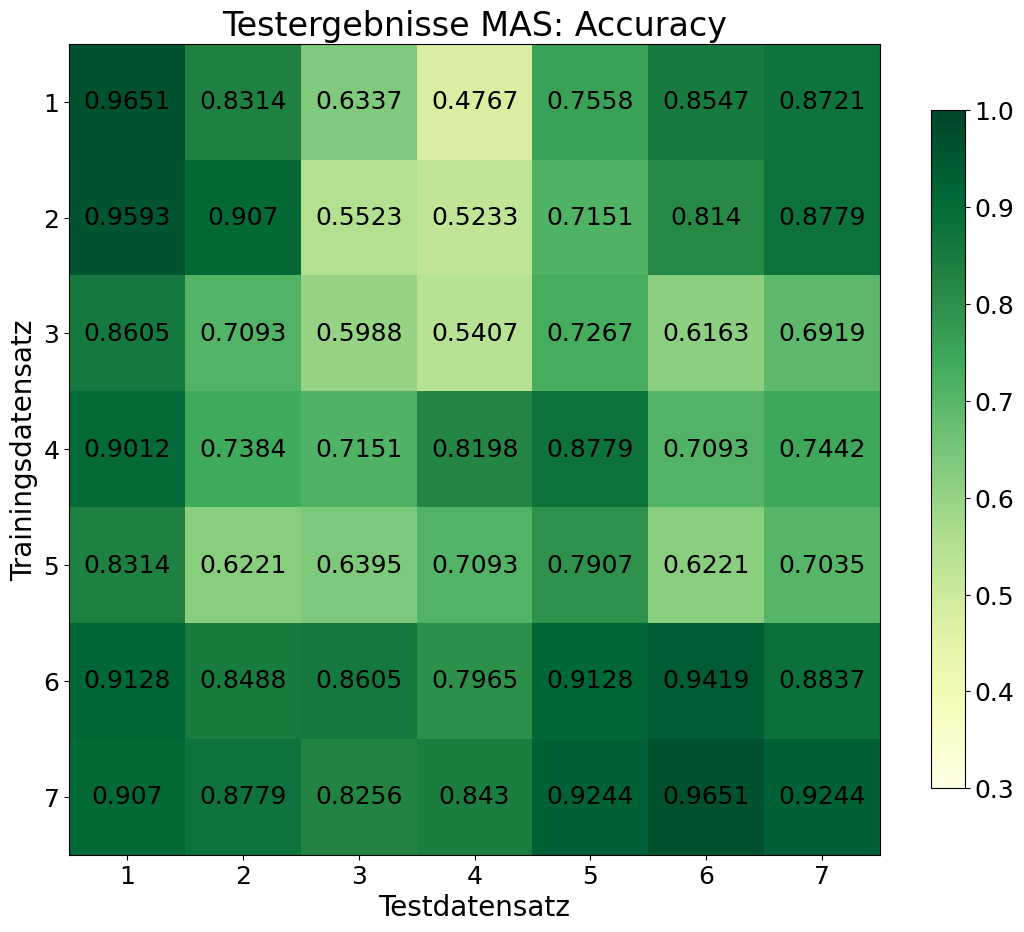

In [187]:
# Plot the test results
fig, ax = plt.subplots(figsize=(11,11))
im = ax.imshow(test_results_array_MAS, cmap="YlGn", vmin=vmin, vmax=vmax)
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_yticklabels(["1", "2", "3", "4", "5", "6", "7"], fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax.set_xlabel("Testdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax.set_ylabel("Trainingsdatensatz", fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax.set_title("Testergebnisse MAS: Accuracy", fontdict={'fontsize': 24, 'fontweight': 'medium'})
for i in range(7):
    for j in range(7):
        text = ax.text(j, i, round(test_results_array_MAS[i, j], 4), ha="center", va="center", color="black", fontdict={'fontsize': 18, 'fontweight': 'medium'})
fig.tight_layout()

# Add a colorbar with the same color scale
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.7)
cbar.set_ticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
cbar.ax.yaxis.set_tick_params(labelsize=18)                         # Increase the size of the colorbar ticks
cbar.set_ticklabels([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.show()

# Save the plot in the results folder
if save == True:
    fig.savefig('../results/Heatmaps/Heatmap_MAS_' + str(data_percentage) + "_percent_data_" + date + '_try_' + str(try_number) + '.png')

In [188]:
""" # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets
parameter_group = 5     # choose the parameter group    

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(range(1,8), test_results_array_MAS[parameter_group-1,:], marker="o", color= "gray")
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy des Modells trainiert mit MAS auf Parametergruppe " + str(parameter_group))
plt.show() """

' # Plot the accuracy of the model trained on the chosen parameter group over all seven test datasets\nparameter_group = 5     # choose the parameter group    \n\nfig, ax = plt.subplots(figsize=(15,10))\nax.plot(range(1,8), test_results_array_MAS[parameter_group-1,:], marker="o", color= "gray")\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Accuracy des Modells trainiert mit MAS auf Parametergruppe " + str(parameter_group))\nplt.show() '

In [189]:
""" # Plot the accuracy of each model trained on a parameter group over all seven test datasets
fig, ax = plt.subplots(figsize=(15,10))
for i in range(7):
    ax.plot(range(1,8), test_results_array_MAS[i,:], marker="o", label="Parametergruppe " + str(i+1))
ax.set_xlabel("Testdatensatz")
ax.set_ylabel("Accuracy")
ax.set_title("Verlauf der Accuracy der Modelle trainiert mit MAS auf den Parametergruppen 1-7")
ax.legend(bbox_to_anchor=(1, 0.2))
plt.show() """

' # Plot the accuracy of each model trained on a parameter group over all seven test datasets\nfig, ax = plt.subplots(figsize=(15,10))\nfor i in range(7):\n    ax.plot(range(1,8), test_results_array_MAS[i,:], marker="o", label="Parametergruppe " + str(i+1))\nax.set_xlabel("Testdatensatz")\nax.set_ylabel("Accuracy")\nax.set_title("Verlauf der Accuracy der Modelle trainiert mit MAS auf den Parametergruppen 1-7")\nax.legend(bbox_to_anchor=(1, 0.2))\nplt.show() '